In [1]:
import mne
import os
from mne.io import read_raw_fif
import numpy as np
import matplotlib.pyplot as plt
from hytools.vtc_utils import *
from hytools.meg_utils import get_ch_pos
from autoreject import AutoReject
from scipy.io import loadmat, savemat
from brainpipe import feature
%matplotlib notebook

In [187]:
def find_logfile(subj, bloc, log_files):
    ### Find the right logfile for a specific subject and bloc in a list of log_files
    # (typically the list of files in the log folder, obtained by "os.listdir(LOGS_DIR)")
    for file in log_files:
        if file[7:9] ==  subj and file[10] == bloc:
            break
    return file

def find_preprocfile(subj, bloc, log_files):
    ### Find the right logfile for a specific subject and bloc in a list of log_files
    # (typically the list of files in the log folder, obtained by "os.listdir(LOGS_DIR)")
    for file in log_files:
        if file[2:4] ==  subj and file[6] == str(int(bloc)+1):
            break
    return file

def remove_misses_from_events(events):
    
    return events

def split_events_by_VTC(INzone, OUTzone, events):
    INevents = []
    OUTevents = []
    counter = 0
    for i, event in enumerate(events):
        if event[2] == 21:
            try:
                if events[i+1][2] == 99:
                    if counter in INzone:
                        INevents.append(event)
                    if counter in OUTzone:
                        OUTevents.append(event)
            except:
                print('last event')
        elif event[2] == 31:
            try:
                if events[i+1][2] != 99:
                    if counter in INzone:
                        INevents.append(event)
                    if counter in OUTzone:
                        OUTevents.append(event)
            except:
                print('last event')
        counter += 1
    INevents = np.asarray(INevents)
    OUTevents = np.asarray(OUTevents)
    return INevents, OUTevents

def split_events_by_VTC2(INzone, OUTzone, events):
    ### keeps all trials, miss included
    INevents = []
    OUTevents = []
    counter = 0
    for i, event in enumerate(events):
        if event[2] == 21:
            try:
                if counter in INzone:
                    INevents.append(event)
                if counter in OUTzone:
                    OUTevents.append(event)
            except:
                print('last event')
        elif event[2] == 31:
            try:
                if counter in INzone:
                    INevents.append(event)
                if counter in OUTzone:
                    OUTevents.append(event)
            except:
                print('last event')
        counter += 1
    INevents = np.asarray(INevents)
    OUTevents = np.asarray(OUTevents)
    return INevents, OUTevents

def compute_PSD(epochs, sf, epochs_length, f=None):
    if f == None:
        f = [ [4, 8], [8, 12], [12, 20], [20, 30], [30, 60], [60, 90], [90, 120] ]
    # Choose MEG channels
    data = epochs.get_data() # On sort les data de l'objet MNE pour les avoir dans une matrice (un numpy array pour être précis)
    data = data.swapaxes(0,1).swapaxes(1,2) # On réarange l'ordre des dimensions pour que ça correspond à ce qui est requis par Brainpipe
    objet_PSD = feature.power(sf=int(sf), npts=int(sf*epochs_length), width=int((sf*epochs_length)/2), step=int((sf*epochs_length)/4), f=f, method='hilbert1') # La fonction Brainpipe pour créer un objet de calcul des PSD
    data = data[:,0:960,:] # weird trick pour corriger un pb de segmentation jpense
    #print(data.shape)
    psds = objet_PSD.get(data)[0] # Ici on calcule la PSD !
    return psds

def array_topoplot(toplot, ch_xy, showtitle=False, titles=None, savefig=False, figpath=None, vmin=-1, vmax=1):
    #create fig
    fig, ax = plt.subplots(1,len(toplot), figsize=(20,10))
    for i, data in enumerate(toplot):
        image,_ = mne.viz.plot_topomap(data=data, pos=ch_xy, cmap='magma', vmin=vmin, vmax=vmax, axes=ax[i], show=False)
        #option for title
        if showtitle == True:
            ax[i].set_title(titles[i], fontdict={'fontsize': 20, 'fontweight': 'heavy'})
    #add a colorbar at the end of the line (weird trick from https://www.martinos.org/mne/stable/auto_tutorials/stats-sensor-space/plot_stats_spatio_temporal_cluster_sensors.html#sphx-glr-auto-tutorials-stats-sensor-space-plot-stats-spatio-temporal-cluster-sensors-py)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[-1])
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_colorbar.tick_params(labelsize=14)
    #save plot if specified
    if savefig == True:
        plt.savefig(figpath, dpi=300)
    plt.show()

In [241]:
folderpath = '/home/karim/DATA/DATAmeg_gradCPT/'
PREPROC_PATH = folderpath + 'saflow_preproc/'
LOGS_DIR = "/home/karim/pCloudDrive/science/saflow/gradCPT/gradCPT_share_Mac_PC/gradCPT_share_Mac_PC/saflow_data/"
IMG_DIR = '/home/karim/pCloudDrive/science/saflow/images/'
EPOCHS_DIR = folderpath + 'saflow_epoched_NOar/'
PSDS_DIR = '/home/karim/pCloudDrive/science/saflow/DATAmeg_gradCPT/PSDS_NOar/'

FREQS = [ [4, 8], [8, 12], [12, 20], [20, 30], [30, 60], [60, 90], [90, 120] ]
FREQS_NAMES = ['theta', 'alpha', 'lobeta', 'hibeta', 'gamma1', 'gamma2', 'gamma3']

subj_list = ['04', '05', '06', '07']
blocs_list = ['1','2','3', '4', '5', '6']

In [234]:
# Test debug NO ar
### Also : Freq VS Rare epochs

for subj in subj_list:
    for bloc in blocs_list:
        ## Open file
        preproc_file = find_preprocfile(subj, bloc, os.listdir(PREPROC_PATH))
        print(preproc_file)
        raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
        picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)
        
        ## segmentation
        events = mne.find_events(raw)
        event_id = {'Freq': 21, 'Rare': 31}
        baseline = (None, 0.0)
        reject = {'mag': 4e-12}
        tmin, tmax = 0, 0.8
        epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                            tmax=tmax, baseline=baseline, reject=None, picks=picks, preload=True)
        psds = compute_PSD(epochs, epochs.info['sfreq'], epochs_length = 0.8)
        psds = np.mean(psds, axis=2)
        print(psds.shape)
        0/0
        

SA04_02_preprocessed.fif.gz


<ipython-input-234-76654506b95f>:9: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_02_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
/home/karim/electrophy/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/karim/electrophy/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

(7, 270, 598)


ZeroDivisionError: division by zero

In [235]:
##### OPEN PREPROC FILES AND SEGMENT THEM

for subj in subj_list:
    for bloc in blocs_list:
        ### Find logfile to extract VTC
        log_file = find_logfile(subj,bloc,os.listdir(LOGS_DIR))
        VTC, INbounds, OUTbounds, INzone, OUTzone = get_VTC_from_file(LOGS_DIR + log_file, lobound=None, hibound=None)
        ### Load pre-processed datafile
        preproc_file = find_preprocfile(subj, bloc, os.listdir(PREPROC_PATH))
        raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
        picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)

        ### Set some constants for epoching

        baseline = (None, 0.0)
        reject = {'mag': 4e-12}
        tmin, tmax = 0, 0.8

        ### Find events, split them by IN/OUT and start epoching
        events = mne.find_events(raw)
        INevents, OUTevents = split_events_by_VTC(INzone, OUTzone, events)
        try:
            event_id = {'Freq': 21, 'Rare': 31}
            INepochs = mne.Epochs(raw, events=INevents, event_id=event_id, tmin=tmin,
                            tmax=tmax, baseline=baseline, reject=reject, picks=picks, preload=True)
        except:
            event_id = {'Freq': 21}
            INepochs = mne.Epochs(raw, events=INevents, event_id=event_id, tmin=tmin,
                            tmax=tmax, baseline=baseline, reject=reject, picks=picks, preload=True)
            
        try:
            event_id = {'Freq': 21, 'Rare': 31}
            OUTepochs = mne.Epochs(raw, events=OUTevents, event_id=event_id, tmin=tmin,
                            tmax=tmax, baseline=baseline, reject=reject, picks=picks, preload=True)
        except:
            event_id = {'Freq': 21}
            OUTepochs = mne.Epochs(raw, events=OUTevents, event_id=event_id, tmin=tmin,
                            tmax=tmax, baseline=baseline, reject=reject, picks=picks, preload=True)
            

        ### Autoreject detects, rejects and interpolate artifacted epochs
        #ar = AutoReject()
        #INepochs_clean = ar.fit_transform(INepochs)
        #OUTepochs_clean = ar.fit_transform(OUTepochs)
        
        INepochs.save(EPOCHS_DIR + 'SA' + subj + '_' + bloc + '_IN_epo.fif.gz')
        OUTepochs.save(EPOCHS_DIR + 'SA' + subj + '_' + bloc + '_OUT_epo.fif.gz')

<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_02_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_03_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_04_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

last event


<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_05_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_06_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA04_07_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

last event


<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA05_03_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA05_04_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA05_05_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

last event


<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA06_04_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA06_05_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA06_06_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

last event


<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA06_07_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA07_02_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA07_03_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

last event


<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA07_05_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA07_06_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = read_raw_fif(PREPROC_PATH + preproc_file, preload=True)
<ipython-input-235-e58fe95cfb9e>:10: RuntimeWarning: This filename (/home/karim/DATA/DATAmeg_gradCPT/saflow_preproc/SA07_07_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw

In [236]:
### OPEN SEGMENTED FILES AND COMPUTE PSDS

for subj in subj_list:
    for bloc in blocs_list:
        for zone in ['IN', 'OUT']:
            data = mne.read_epochs(EPOCHS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_epo.fif.gz')
            psds = compute_PSD(data, data.info['sfreq'], epochs_length = 0.8)
            psds = np.mean(psds, axis=2)
            for i, freq_name in enumerate(FREQS_NAMES):
                PSD_save = psds[i]
                savemat(PSDS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_' + freq_name + '.mat', {'PSD': PSD_save})


/home/karim/electrophy/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


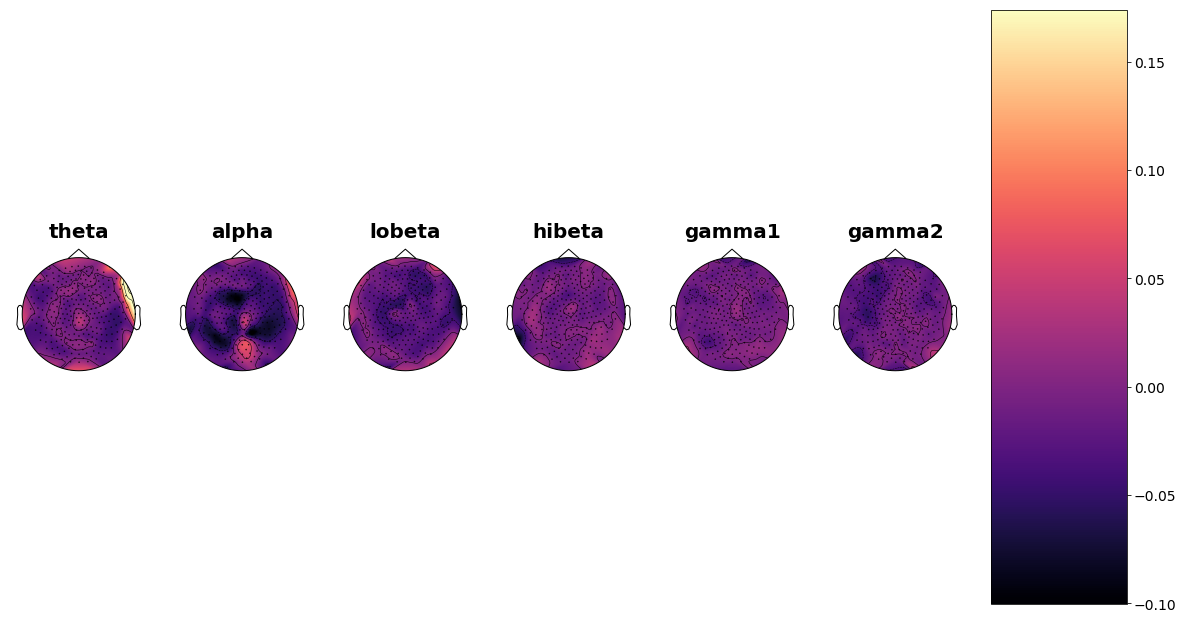

In [242]:
### OPEN PSDS AND CREATE TOPOPLOTS

#### ALL SUBJ TOPOPLOT

# create a pdf with psd topoplots
ch_file = '/home/karim/pCloudDrive/science/saflow/DATAmeg_gradCPT/20190411/SA04_SAflow-yharel_20190411_02.ds'
raw = mne.io.read_raw_ctf(ch_file)
ch_xy = get_ch_pos(raw)

toplot = []
for i, freq_name in enumerate(FREQS_NAMES):
    alldata = []
    for zone in ['IN', 'OUT']:
        zonedata = []
        for subj in subj_list:
            subjdata = []
            for bloc in blocs_list:
                mat = loadmat(PSDS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_' + freq_name + '.mat')
                data = mat['PSD']
                if subjdata == []:
                    subjdata = data
                else:
                    subjdata = np.hstack((subjdata, data))
            subjdata = np.mean(subjdata, axis=1) # average blocs
            zonedata.append(subjdata)
        alldata.append(np.asarray(zonedata))
    alldata = np.asarray(alldata)
    alldata = np.mean(alldata, axis=1) # average subjects
    toplot.append((alldata[0] - alldata[1])/alldata[1])
array_topoplot(toplot, ch_xy, showtitle=True, titles=FREQS_NAMES, savefig=True, figpath=IMG_DIR + 'IN_vs_OUT_PSD_NOar_4subj.png', vmin=np.min(np.min(toplot)), vmax=np.max(np.max(toplot)))
    #array_topoplot(alldata[1], ch_xy, showtitle=False, titles=None, savefig=False, figpath=None, vmin=-1, vmax=1)

    #print(alldata[1])

/home/karim/electrophy/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


04


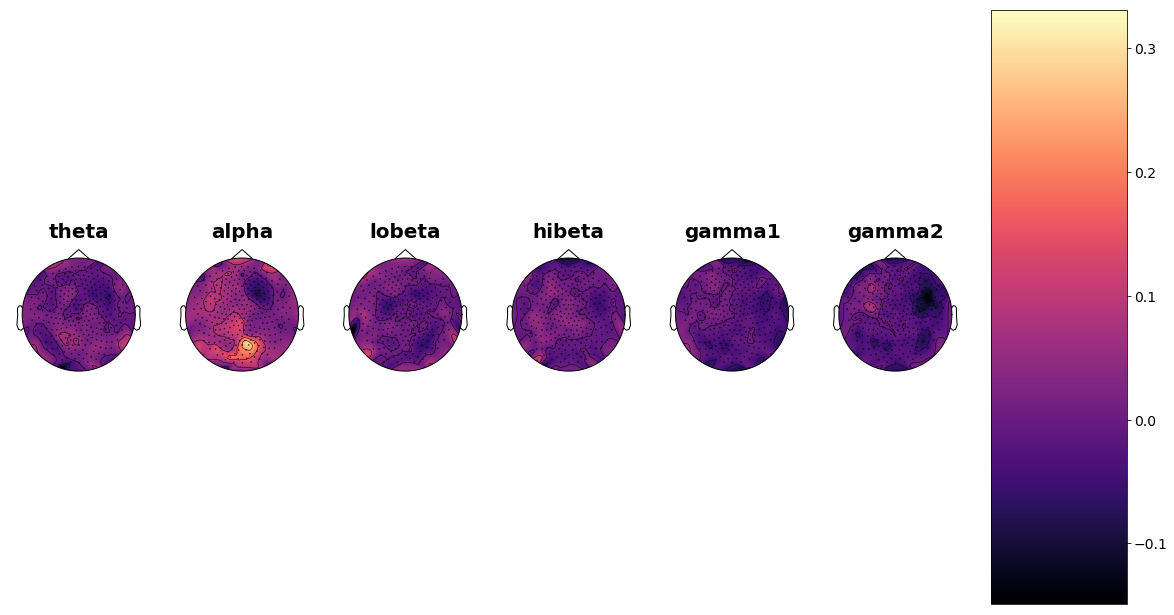

05


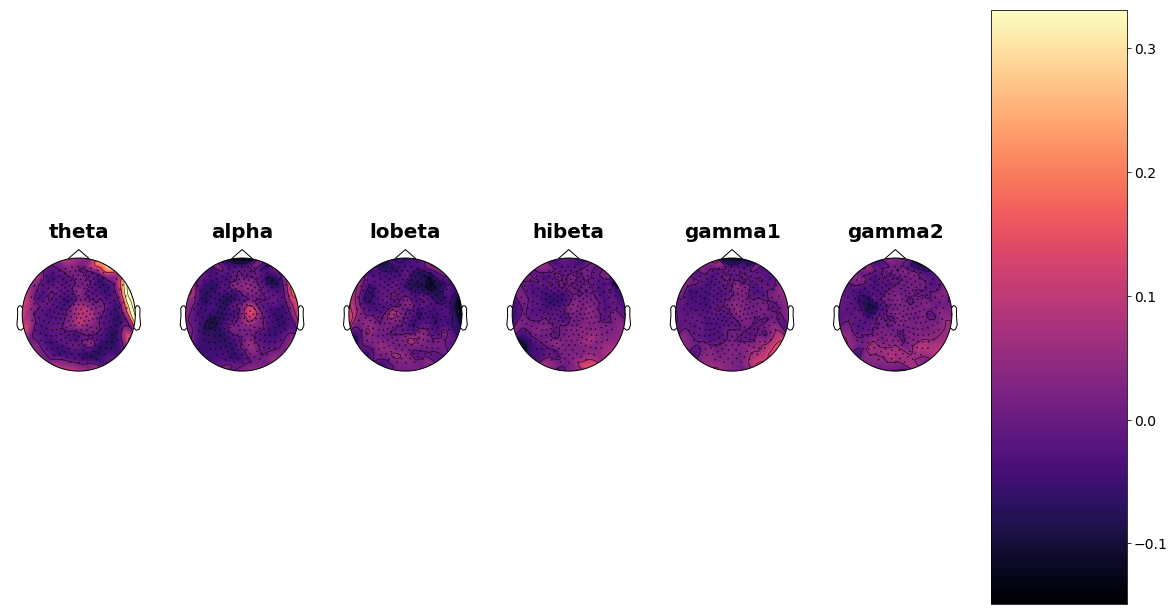

06


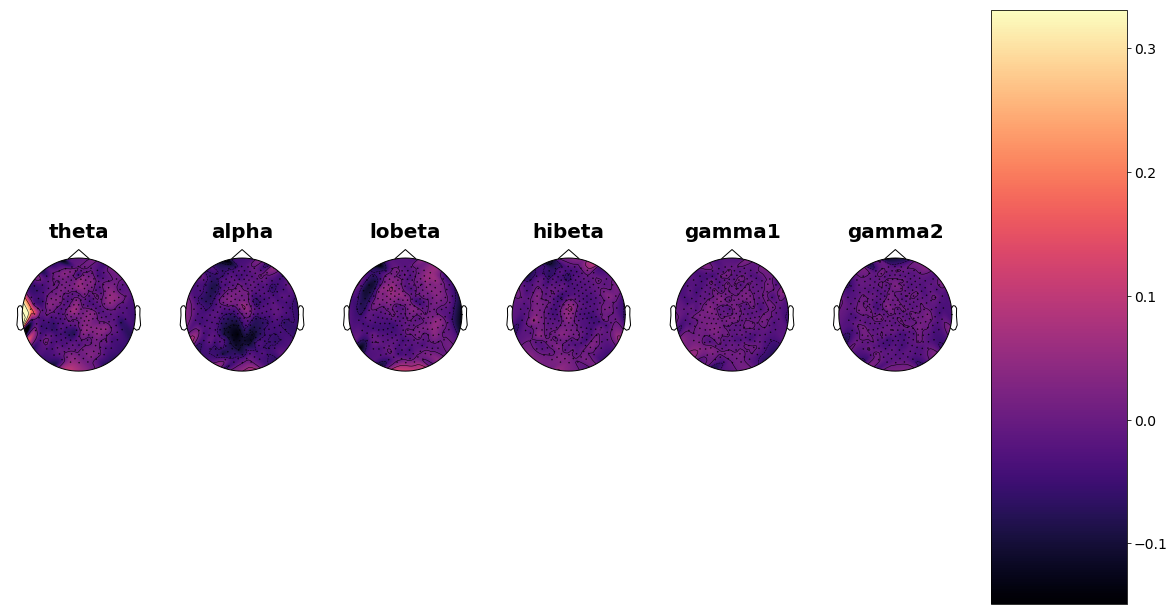

07


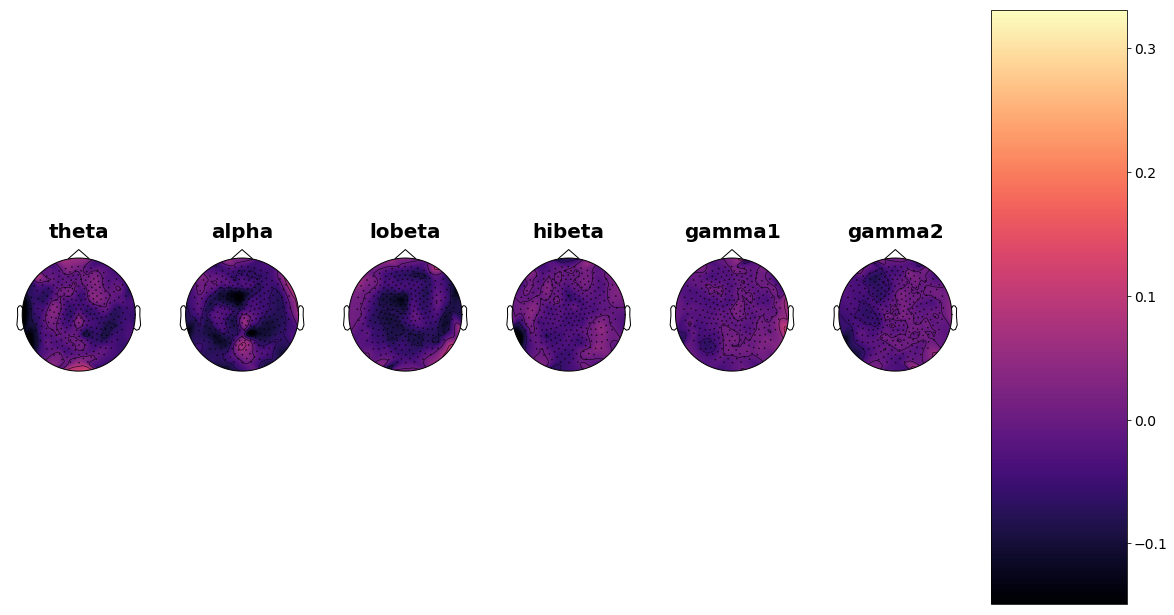

In [238]:
### OPEN PSDS AND CREATE TOPOPLOTS

#### INDIVIDUAL SUBJ TOPOPLOT

# create a pdf with psd topoplots
ch_file = '/home/karim/pCloudDrive/science/saflow/DATAmeg_gradCPT/20190411/SA04_SAflow-yharel_20190411_02.ds'
raw = mne.io.read_raw_ctf(ch_file)
ch_xy = get_ch_pos(raw)

toplot = []
for i, freq_name in enumerate(FREQS_NAMES):
    alldata = []
    for zone in ['IN', 'OUT']:
        zonedata = []
        for subj in subj_list:
            subjdata = []
            for bloc in blocs_list:
                mat = loadmat(PSDS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_' + freq_name + '.mat')
                data = mat['PSD']
                if subjdata == []:
                    subjdata = data
                else:
                    subjdata = np.hstack((subjdata, data))
            subjdata = np.mean(subjdata, axis=1) # average blocs
            zonedata.append(subjdata)
        alldata.append(np.asarray(zonedata))
    #alldata = np.mean(np.asarray(alldata), axis=1) # average subjects
    alldata = np.asarray(alldata)
    toplot.append((alldata[0] - alldata[1])/alldata[1])
toplot = np.asarray(toplot)

for i, subj in enumerate(subj_list):
    print(subj)
    array_topoplot(toplot[:,i,:], ch_xy, showtitle=True, titles=FREQS_NAMES, savefig=True, figpath=IMG_DIR + 'IN_vs_OUT_PSD' + '_SA' + subj + '_NOar.png', vmin=np.min(np.min(toplot)), vmax=np.max(np.max(toplot)))
    #array_topoplot(alldata[1], ch_xy, showtitle=False, titles=None, savefig=False, figpath=None, vmin=-1, vmax=1)

    #print(alldata[1])

In [98]:
### ML single subject classification of IN vs OUT epochs
# - single-features
# - CV k-fold (maybe 10 ?)
# - LDA, RF, kNN ?
for subj in subj_list:
    all_freq_data = []
    for i, freq_name in enumerate(FREQS_NAMES):
        zonedata = []
        y = np.array([])
        for zone in ['IN', 'OUT']:
            blocdata = []
            for bloc in blocs_list:
                mat = loadmat(PSDS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_' + freq_name + '.mat')
                data = mat['PSD']
                if blocdata == []:
                    blocdata = data
                else:
                    blocdata = np.hstack((blocdata, data))
            vstackif zone == 'IN':
                y = np.vstack((y, np.ones((blocdata.shape[1],1)))) ### 1 = IN
            else:
                y = np.vstack((y, np.zeros((blocdata.shape[1],1))))### 0 = OUT
            print(y.shape)
            
            if zonedata == []:
                zonedata = blocdata
            else:
                zonedata = np.hstack((zonedata, blocdata))
        if all_freq_data == []:
            all_freq_data = zonedata
        else:
            all_freq_data = np.vstack((all_freq_data, zonedata))
    print('SA' + subj)
    print(all_freq_data.shape)
                
                    
#### Résultat on veut : elec * freq X trials(IN+OUT) = 1890 X N_trials_tot



/home/karim/electrophy/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [80]:
alldata_allfreqs = []
for i, freq_name in enumerate(FREQS_NAMES):
    alldata = []
    for zone in ['IN', 'OUT']:
        zonedata = []
        for subj in subj_list:
            subjdata = []
            for bloc in blocs_list:
                mat = loadmat(PSDS_DIR + 'SA' + subj + '_' + bloc + '_' + zone + '_' + freq_name + '.mat')
                data = mat['PSD']
                if subjdata == []:
                    subjdata = data
                else:
                    subjdata = np.hstack((subjdata, data))
            zonedata.append(subjdata)
        alldata.append(zonedata)
    alldata_allfreqs.append(alldata) ### First dimension is freq_band, second is IN/OUT, third is subject, fourth is elec X trials matrix


/home/karim/electrophy/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
### Objectif : 
# get one epoched file for freq and rare AND RESP for each subj
# PLOT TOPO DE L'AMPLITUDE À ENVIRON 150MS APRES RESP
# COMPARER BLOC RESP GAUCHE AVEC BLOC RESP DROIT

##### POUR MIKE : implémenter calcul de la VTC sur Python, à partir du fichier de log


#for file in file_list:
file = file_list[-2]


fname = preproc_path + file
subj = file[:4]
bloc = file[6]

raw = read_raw_fif(fname, preload=True)
picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False)

In [22]:
log_files = os.listdir(LOGS_DIR)

file = find_logfile(subj,bloc,log_files)
VTC, INbounds, OUTbounds, INzone, OUTzone = get_VTC_from_file(LOGS_DIR + file, lobound=0.25, hibound=0.75)

INbounds

[(10, 13),
 (46, 70),
 (158, 184),
 (210, 249),
 (355, 373),
 (401, 418),
 (469, 485)]

In [ ]:
events = mne.find_events(raw)
event_id = {'Freq': 21, 'Rare': 31}
color = {21: 'green', 31: 'yellow'}
mne.viz.plot_events(OUTevents, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id);

In [111]:

a = []
a = np.array(a)
b = np.zeros((5,0))
c = np.hstack((a,b))
c

ValueError: all the input arrays must have same number of dimensions

In [ ]:
ep = read_raw_fif('/home/karim/DATA/MEG_gradCPT/saflow_epoched/SA04_1_IN.fif')

In [ ]:
INevoked_freq = INepochs['Freq'].average()
INevoked_rare = INepochs['Rare'].average()
OUTevoked_freq = OUTepochs['Freq'].average()
OUTevoked_rare = OUTepochs['Rare'].average()


In [ ]:
a = 1

if a >> 1:
    print('lol')
else:
    print('nana')

In [ ]:
times = np.arange(0.1, 0.801, 0.1)
OUTepochs['Rare'].average().plot_topomap(times=times, time_unit='s', title='Rare');
plt.savefig(IMG_DIR + 'evoked_topo_OUTrare.png', dpi=800)

In [ ]:
OUTepochs['Freq'].average().plot_topomap(times=times, time_unit='s', title='Frequent');
plt.savefig(IMG_DIR + 'evoked_topo_OUTfreq.png', dpi=800)

In [ ]:


ar = AutoReject()
INepochs_clean = ar.fit_transform(INepochs)

In [ ]:
### Faire une fonction qui prend un bloc, va chercher le fichier de log associé, calcule la VTC et les IN/OUT bounds
### segmente le fichier et sépare les epochs dans deux fichiers en fonction de la condition de chaque epoch

INepochs_clean.average().plot_topomap(times=times, time_unit='s');